# Meteo 515 – Assignment 6 – Power spectra

In [1]:
from __future__ import division, print_function
#from collections import OrderedDict
#from itertools import chain
#import datetime as dt

#import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.fftpack as sft
import scipy.optimize as so
#import scipy.stats as ss
#import sklearn as skl
import statsmodels.api as sm

In [2]:
plt.style.use('seaborn-darkgrid')
%matplotlib notebook

## Load the data

In [3]:
amo_fpath = './data/amon.us.long.data'

amo_raw = np.genfromtxt(amo_fpath, skip_header=1, skip_footer=4)[:,1:]

with open(amo_fpath, 'r') as f: yr_range = f.readline().split()
t_amo = pd.date_range(start='{}/01/01'.format(yr_range[0]), freq='MS', periods=amo_raw.size)
amo_ndt_us = amo_raw.reshape((amo_raw.size,))

amo = pd.DataFrame({'amo': amo_ndt_us}, index=t_amo)
amo['julian_date'] = amo.index.to_julian_date()               # Julian Date (decimal days)
amo['t_elapsed'] = amo.julian_date - amo.julian_date.iloc[0]  # elapsed time (decimal days)
amo['year'] = amo.index.year                                  # integer year for each data point
amo['decyear'] = amo.index.year + (amo.index.month-1)/12      # decimal year

amo[amo == -99.99] = np.nan
amo.dropna(inplace=True)

#> time period specified in the assignment
t_start, t_end = 1900, 2017
t_dur = t_end - t_start + 1  # amo.index.year.unique().size
time_period = (amo.year >= t_start) & (amo.year <= t_end)  # can also use amo.between_time()
amo = amo.loc[time_period]

## i) Interpolate the monthly ts to a ts with constant time step?

It seems to me that this should be done, since a time series of true monthly averages has time steps that depend on the specific month (as well as on leap vs non-leap for Feb.). But not worrying about it for now.

## a) FFT-relevant properties of the time series

In [4]:
#T_td = amo.index[-1] - amo.index[0]  # Timedelta
#T_days = T_td.days
#T_sec = T_days * 3600*24
T_months = t_dur * 12
#T_years = 
#days_year_avg = T_days / (t_end - t_start)

N = amo.index.size
delta_t = T_months/N
omega_0 = 2*np.pi/T_months  # fundamental frequency for the period T: smallest "resolvable" frequency
omega_N = 2*np.pi/(2*delta_t)  # Nyquist frequency: highest "detectable" frequency (really 4 delta_t)

s = f'''
period \U0001D447 = {T_months} months = ... days
number of time steps \U0001D441 = {N}
interval length \U0001D6E5\U0001D447 = {delta_t} months
fundamental frequency \U0001D714\u2080 = {omega_0:.3g} per month = ... 
Nyquist frequency \U0001D714_N = {omega_N:.3g} per month
''' # note that the chars can also be copied in: 𝜔 
print(s.strip())

period 𝑇 = 1416 months = ... days
number of time steps 𝑁 = 1416
interval length 𝛥𝑇 = 1.0 months
fundamental frequency 𝜔₀ = 0.00444 per month = ... 
Nyquist frequency 𝜔_N = 3.14 per month


## b) Calculate fast Fourier transform (FFT)

In [5]:
F_k = sft.rfft(amo.amo.values)  # coeffs for the positive side

power = F_k**2/N
freq_per_month = np.arange(F_k.size)*omega_0

## c) Calculate AR(1) power spectrum and significance levels

In [6]:
AR1_model = sm.tsa.ARMA(amo.amo.values, order=(1, 0)).fit()

S_h = sft.rfft(AR1_model.predict())
power_AR1 = S_h**2/N

M_sp = N  # number of spectral elements
h = np.arange(M_sp)
Ssq_AR1_theory_fn = \
    lambda h, A, rho: A*(1-rho**2)/(1 - 2*rho*np.cos(h*np.pi/M_sp) + rho**2)

#Ssq_AR1_theory_fit = so.curve_fit(Ssq_AR1_theory_fn, h, F_k*N, p0=[1, 0.7])
#Ssq_AR1_theory = Ssq_AR1_theory_fn(h, *Ssq_AR1_theory_fit[0])

Ssq_AR1_theory = Ssq_AR1_theory_fn(h, 1, AR1_model.params[1])
Ssq_AR1_theory *= F_k.sum()/Ssq_AR1_theory.sum()*N
power_AR1_theory = Ssq_AR1_theory/N

/usr/local/miniconda3/envs/py3d/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/miniconda3/envs/py3d/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/usr/local/miniconda3/envs/py3d/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`

## d) Plot power spectra as power vs frequency

<IPython.core.display.Javascript object>


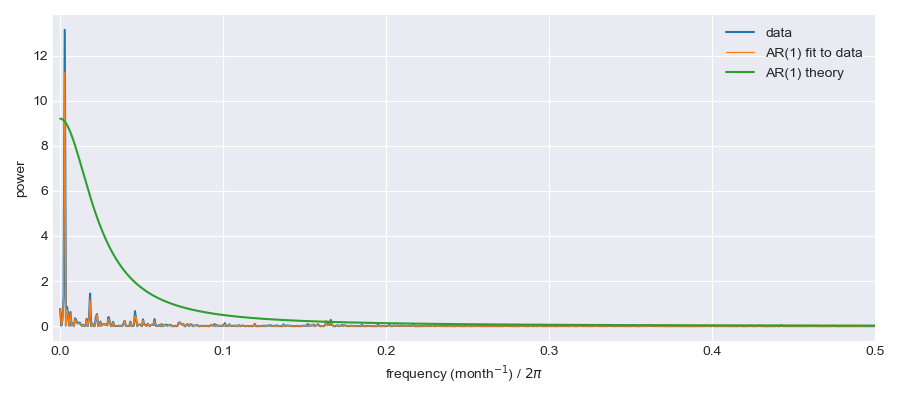

In [7]:
f1, a = plt.subplots(figsize=(9, 4), num='FFT')

f_plot = freq_per_month/(2*np.pi)
a.plot(f_plot, power, label='data')
a.plot(f_plot, power_AR1, lw=0.9, label='AR(1) fit to data')
a.plot(f_plot, power_AR1_theory, label='AR(1) theory')

a.set_xlabel('frequency (month$^{-1}$) / $2\pi$')
a.set_xlim(left=-omega_0, right=(omega_N/(2*np.pi)))
a.set_ylabel('power')
a.legend()

f1.tight_layout();

## e) Plot power spectra as frequency times power vs ln(frequency)

<IPython.core.display.Javascript object>


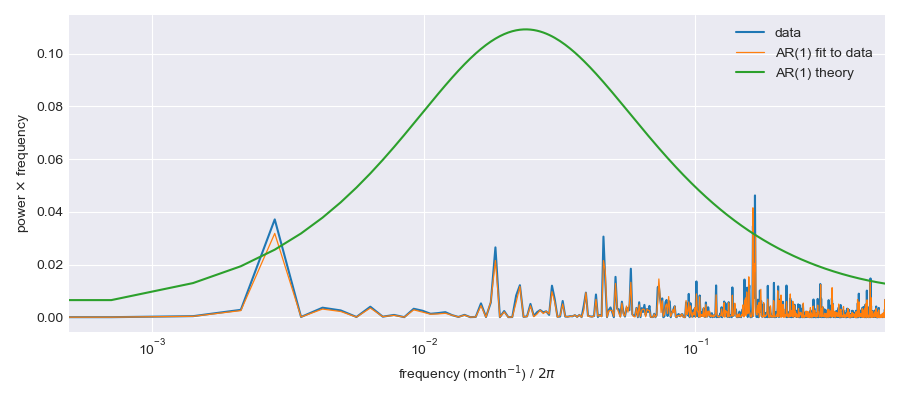

In [8]:
f2, a = plt.subplots(figsize=(9, 4), num='FFT_2')

f_plot = freq_per_month/(2*np.pi)
a.semilogx(f_plot, f_plot*power, label='data')
a.semilogx(f_plot, f_plot*power_AR1, lw=0.9, label='AR(1) fit to data')
a.semilogx(f_plot, f_plot*power_AR1_theory, label='AR(1) theory')

a.set_xlabel('frequency (month$^{-1}$) / $2\pi$')
a.set_xlim(right=(omega_N/(2*np.pi)))
a.set_ylabel(r'power $\times$ frequency')
a.legend()

f2.tight_layout();